<a href="https://colab.research.google.com/github/ma850419/FlexibleNet/blob/main/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
os.listdir()

In [56]:
import numpy as np
from osgeo import gdal
filepath = r'/content/PRS_L1_STD_OFFL_20221217082013_20221217082018_0001_HCO_VNIR.tif'
# https://stackoverflow.com/questions/43684072/how-to-import-multiple-bands-from-an-image-into-numpy
# Load one GeoTIFF image using GDAL
dataset = gdal.Open(filepath)
projInfo = dataset.GetProjection()
trans = dataset.GetGeoTransform()
print(projInfo,trans)
#image = np.zeros(( dataset.RasterXSize,dataset.RasterYSize,dataset.RasterCount))
image = dataset.ReadAsArray()
print(type(image))  # <class 'numpy.ndarray'>
print(image.shape) 
print(image.dtype)  

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]] (35.49288558959961, 0.0003509521484375, 0.0, 33.71284866333008, 0.0, -0.0002593994140625)
<class 'numpy.ndarray'>
(63, 1231, 1245)
float32


In [40]:
import os

!ls -l

total 184868
-rw-r--r-- 1 root root 189292965 Apr  1 10:52 PRS_L1_STD_OFFL_20221217082013_20221217082018_0001_HCO_VNIR.tif
drwxr-xr-x 1 root root      4096 Mar 30 13:53 sample_data


In [4]:
!pip install minisom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.1-py3-none-any.whl size=10609 sha256=709451dabd6d967efc814f931b7852b355fee91ffbf5c8c601944ee1616701ab
  Stored in directory: /root/.cache/pip/wheels/b4/aa/7a/d9a88098f7877aa95dd4f227fe614f75773654baa39b47bba6
Successfully built minisom


In [42]:
import statistics
from minisom import MiniSom
mine=np.zeros((1231*1245,63))
pixels2=np.zeros((1231*1245,63))
pixels3=np.zeros((1231*1245,63))
som_clustered=np.zeros((1231*1245,63))
som = MiniSom(4, 4, 63, sigma=0.5,learning_rate=0.1, neighborhood_function='gaussian')
#mine=zeros((512*512,4))
#pixels2=zeros((600,512*512,4))
#som_clustered=zeros((600,512*512,1))
#for i in range(600):
pixels2= image.reshape(1231*1245,63)
pixels3 = pixels2 != -999
pixels2 = abs(pixels2)*pixels3/300.0
#print( pixels2.min())
#print(me)
#print(pixels2[100000:100100,:])
#print(me)
som.random_weights_init(pixels2)
starting_weights = som.get_weights().copy()  # saving the starting weights
som.train(pixels2, 5000, random_order=False, verbose=True)
print('quantization...')
qnt = som.quantization(pixels2)  # quantize each pixels of the image
    #print(qnt.shape)
clustered = np.zeros((1231*1245,63))
clustered1 = np.zeros((1231*1245,1))
for j, q in enumerate(qnt):  # place the quantized values into a new image
  sn = np.unravel_index(j,shape=((1231*1245)))
    #print(sn)
    #print(me)
   
  #print(q,(mean(q)*6).astype(np.uint8))
  #print(me)
  clustered[sn] = q[:] #(max(q)*6).astype(np.uint8) 
  #print((round(q[:].max()*16*300.0)))
  #print(me)
  clustered1[sn] = (round(q[:].max()*255.0))#.astype(np.uint8) #statistics.mean(q)
 # print(clustered1[sn])
        #print(clustered.shape)
#mine= np.append(mine,clustered,axis=0)#,axis=0)
   # print(clustered1)
#som_clustered[i] =  clustered1
    #print(som_clustered[i])
    #print(me)
#print(mine.shape)

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 0.2173336594087389
quantization...


In [62]:
from osgeo import osr
output_file = "out.tif"
clustered2 = np.zeros((1231,1245))
clustered2 = clustered1.reshape(1231,1245)
# Create gtif
driver = gdal.GetDriverByName("GTiff")
dst_ds = driver.Create(output_file, clustered2.shape[1], clustered2.shape[0],1, gdal.GDT_Float32 )
# top left x, w-e pixel resolution, rotation, top left y, rotation, n-s pixel resolution
#dst_ds.SetGeoTransform( [ -180, 0.025, 0, 90, 0, -0.025 ] )

# set the reference info 
dst_ds.SetGeoTransform(trans)
band = dst_ds.GetRasterBand(1)
dst_ds.SetProjection( projInfo )
band.WriteArray(clustered2)
band.FlushCache()
# write the band
#dst_ds.GetRasterBand(1).SetNoDataValue(255) #I set my nodata values in array to be 255
#dst_ds.GetRasterBand(1).WriteArray(clustered2)

In [63]:
!ls -l

total 190848
-rw-r--r-- 1 root root  12240808 Apr  1 12:19 out.tif
-rw-r--r-- 1 root root 189292965 Apr  1 10:52 PRS_L1_STD_OFFL_20221217082013_20221217082018_0001_HCO_VNIR.tif
drwxr-xr-x 1 root root      4096 Mar 30 13:53 sample_data


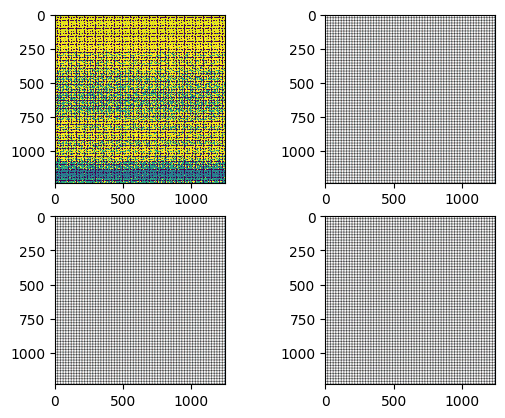

<Figure size 2000x400 with 0 Axes>

In [44]:
import matplotlib.pyplot as plt
#print(clustered.shape, clustered1.shape)
clustered2 = np.zeros((1231,1245))
image1=image.reshape(1231,1245,63)
clustered3 = np.zeros((1231,1245,3))
clustered3[:,:,0]=image1[:,:,60]
clustered3[:,:,1]=image1[:,:,35]
clustered3[:,:,2]=image1[:,:,20]
#print(clustered3, clustered2)
clustered2 = clustered1.reshape(1231,1245)
f, axarr = plt.subplots(2,2)
plt.figure(figsize = (20,4))
axarr[0,0].imshow(clustered2,interpolation='nearest')
#plt.show()
axarr[0,1].imshow(clustered3)
#plt.show()
clustered3[:,:,0]=image1[:,:,50]
clustered3[:,:,1]=image1[:,:,30]
clustered3[:,:,2]=image1[:,:,15]
axarr[1,0].imshow(clustered3)
#plt.show()
clustered3[:,:,0]=image1[:,:,30]
clustered3[:,:,1]=image1[:,:,20]
clustered3[:,:,2]=image1[:,:,10]
axarr[1,1].imshow(clustered3)
plt.show()

In [ ]:
def unique(list1):
 
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    for x in unique_list:
        print(x)

In [71]:
list1=[]
list1= np.append(list1,clustered1)
#list1=clustered1.tolist()
unique(list1)
clustered2.show()

0.0
33.0
35.0
4.0
5.0
37.0
40.0
42.0
46.0
47.0
15.0
28.0


AttributeError: ignored